In [17]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers

from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

tf.keras.backend.set_floatx('float32')

In [18]:
print(tf.__version__)

2.13.0


In [19]:
# Load the dataset
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

# Scale the labels
scale_factor = 1000.0
# Scale the training set's label.
train_df["median_house_value"] /= scale_factor

# Scale the test set's label
test_df["median_house_value"] /= scale_factor

# Shuffle the examples
train_df = train_df.reindex(np.random.permutation(train_df.index))

### Representing latitude and longitude as floating-point features:

In [20]:
# Keras Input tensors of float values.
inputs = {
    'latitude':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='latitude'),
    'longitude':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='longitude')
}

#### Defining functions to create and train a model, and a plotting function:

In [21]:
def create_model(my_inputs, my_outputs, my_learning_rate):

  model = tf.keras.Model(inputs=my_inputs, outputs=my_outputs)

  # Construct the layers into a model that TensorFlow can execute.
  model.compile(optimizer=tf.keras.optimizers.experimental.RMSprop(
      learning_rate=my_learning_rate),
      loss="mean_squared_error",
      metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model


def train_model(model, dataset, epochs, batch_size, label_name):
  """Feed a dataset into the model in order to train it."""

  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True)

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch

  # Isolate the mean absolute error for each epoch.
  hist = pd.DataFrame(history.history)
  rmse = hist["root_mean_squared_error"]

  return epochs, rmse


def plot_the_loss_curve(epochs, rmse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([rmse.min()*0.94, rmse.max()* 1.05])
  plt.show()

### Training the model with floating-point representations:

In [22]:
# The following variables are the hyperparameters.
learning_rate = 0.05
epochs = 30
batch_size = 100
label_name = 'median_house_value'

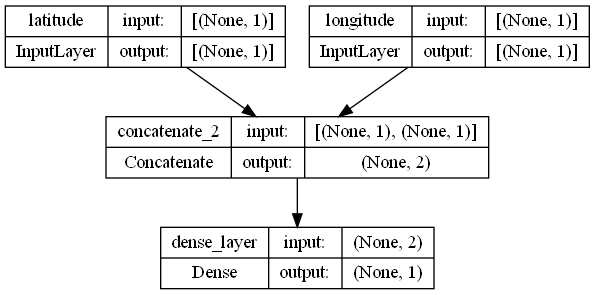

In [23]:
# The two Input layers are concatenated so they can be passed as a single
# tensor to a Dense layer.
preprocessing_layer = tf.keras.layers.Concatenate()(inputs.values())

dense_output = layers.Dense(units=1, name='dense_layer')(preprocessing_layer)

outputs = {
  'dense_output': dense_output
}

# Create and compile the model's topography.
my_model = create_model(inputs, outputs, learning_rate)

# Display the model's architecture.
tf.keras.utils.plot_model(my_model, show_shapes=True)

Epoch 1/30


c:\Users\AMD\Anaconda3\envs\FelipeAlbuquerque\lib\site-packages\keras\src\engine\functional.py:639: UserWarning: Input dict contained keys ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


170/170 [==============================] - 0s 1ms/step - loss: 22496.4961 - root_mean_squared_error: 149.9883
Epoch 2/30
170/170 [==============================] - 0s 870us/step - loss: 13559.8066 - root_mean_squared_error: 116.4466
Epoch 3/30
170/170 [==============================] - 0s 870us/step - loss: 13496.6699 - root_mean_squared_error: 116.1752
Epoch 4/30
170/170 [==============================] - 0s 876us/step - loss: 13459.7930 - root_mean_squared_error: 116.0163
Epoch 5/30
170/170 [==============================] - 0s 947us/step - loss: 13409.3555 - root_mean_squared_error: 115.7988
Epoch 6/30
170/170 [==============================] - 0s 994us/step - loss: 13340.5479 - root_mean_squared_error: 115.5013
Epoch 7/30
170/170 [==============================] - 0s 882us/step - loss: 13318.6982 - root_mean_squared_error: 115.4067
Epoch 8/30
170/170 [==============================] - 0s 864us/step - loss: 13283.2998 - root_mean_squared_error: 115.2532
Epoch 9/30
170/170 [=========

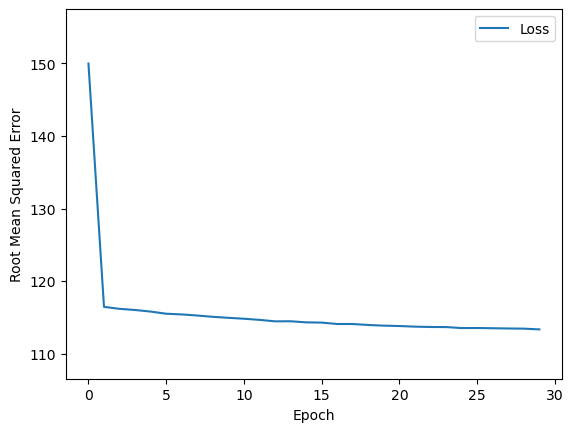


: Evaluate the new model against the test set:
30/30 [==============================] - 0s 931us/step - loss: 12180.7197 - root_mean_squared_error: 110.3663


[12180.7197265625, 110.36629486083984]

In [24]:
# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

# Print out the model summary.
my_model.summary(expand_nested=True)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = np.array(test_features.pop(label_name))
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

### Representing latitude and longitude as floating-point values does not have much predictive power. For example, neighborhoods at latitude 35 are not 36/35 more valuable (or 35/36 less valuable) than houses at latitude 36. Representing `latitude` and `longitude` as floating-point values provides almost no predictive power. We're only using the raw values to establish a baseline for future experiments with better representations.

### Representing latitude and longitude in buckets:

In [25]:
resolution_in_degrees = 1.0

# Create a list of numbers representing the bucket boundaries for latitude.
latitude_boundaries = list(np.arange(int(min(train_df['latitude'])),
                                     int(max(train_df['latitude'])),
                                     resolution_in_degrees))
print("latitude boundaries: " + str(latitude_boundaries))

# Create a Discretization layer to separate the latitude data into buckets.
latitude = tf.keras.layers.Discretization(
    bin_boundaries=latitude_boundaries,
    name='discretization_latitude')(inputs.get('latitude'))

# Number of categories is the length of latitude_boundaries plus one.
latitude = tf.keras.layers.CategoryEncoding(
    num_tokens=len(latitude_boundaries) + 1,
    output_mode='one_hot',
    name='category_encoding_latitude')(latitude)

# Create a list of numbers representing the bucket boundaries for longitude.
longitude_boundaries = list(np.arange(int(min(train_df['longitude'])),
                                      int(max(train_df['longitude'])),
                                      resolution_in_degrees))

print("longitude boundaries: " + str(longitude_boundaries))

# Create a Discretization layer to separate the longitude data into buckets.
longitude = tf.keras.layers.Discretization(
    bin_boundaries=longitude_boundaries,
    name='discretization_longitude')(inputs.get('longitude'))

# Number of categories is the length of longitude_boundaries plus one.
longitude = tf.keras.layers.CategoryEncoding(
    num_tokens=len(longitude_boundaries) + 1,
    output_mode='one_hot',
    name='category_encoding_longitude')(longitude)

# Concatenate latitude and longitude into a single tensor as input for the Dense layer.
concatenate_layer = tf.keras.layers.Concatenate()([latitude, longitude])

dense_output = layers.Dense(units=1, name='dense_layer')(concatenate_layer)

# Define an output dictionary we'll send to the model constructor.
outputs = {
  'dense_output': dense_output
}

latitude boundaries: [32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0]
longitude boundaries: [-124.0, -123.0, -122.0, -121.0, -120.0, -119.0, -118.0, -117.0, -116.0, -115.0]


### Training the model with bucket representations:

Epoch 1/35
170/170 [==============================] - 0s 953us/step - loss: 51963.1211 - root_mean_squared_error: 227.9542
Epoch 2/35
170/170 [==============================] - 0s 959us/step - loss: 44559.6953 - root_mean_squared_error: 211.0917
Epoch 3/35
170/170 [==============================] - 0s 994us/step - loss: 37989.8789 - root_mean_squared_error: 194.9099
Epoch 4/35
170/170 [==============================] - 0s 965us/step - loss: 32209.1367 - root_mean_squared_error: 179.4690
Epoch 5/35
170/170 [==============================] - 0s 941us/step - loss: 27203.0898 - root_mean_squared_error: 164.9336
Epoch 6/35
170/170 [==============================] - 0s 947us/step - loss: 22938.6543 - root_mean_squared_error: 151.4551
Epoch 7/35
170/170 [==============================] - 0s 929us/step - loss: 19439.7305 - root_mean_squared_error: 139.4264
Epoch 8/35
170/170 [==============================] - 0s 953us/step - loss: 16641.4336 - root_mean_squared_error: 129.0017
Epoch 9/35
170/1

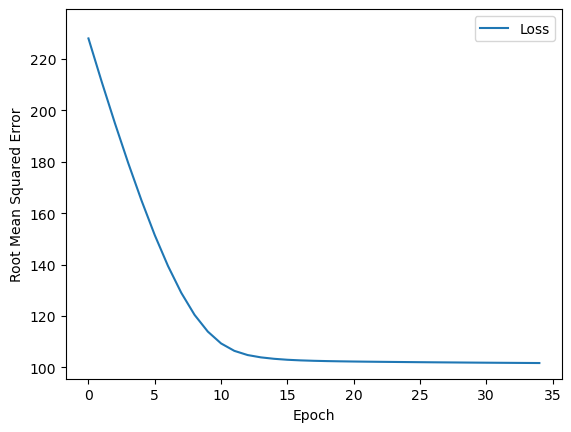


: Evaluate the new model against the test set:
30/30 [==============================] - 0s 1000us/step - loss: 10197.6289 - root_mean_squared_error: 100.9833


[10197.62890625, 100.98330688476562]

In [26]:
# The following variables are the hyperparameters.
learning_rate = 0.04
epochs = 35

# Build the model.
my_model = create_model(inputs, outputs, learning_rate)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

# Print out the model summary.
my_model.summary(expand_nested=True)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

## Bucket representation outperformed floating-point representations. However, you can still do far better.

## Representing location as a feature cross should produce better results.

### Before, we had represented latitude in one-dimensional buckets and longitude in one-dimensional buckets. But real-world locations exist in two dimensions, so we need to work with a grid, obtained by crossing the latitude and longitude buckets.

### The model will learn separate weights for each of the cells.

In [27]:
resolution_in_degrees = 1.0

# Create a list of numbers representing the bucket boundaries for latitude.
latitude_boundaries = list(np.arange(int(min(train_df['latitude'])),
                                     int(max(train_df['latitude'])),
                                     resolution_in_degrees))

# Create a Discretization layer to separate the latitude data into buckets.
latitude = tf.keras.layers.Discretization(
    bin_boundaries=latitude_boundaries,
    name='discretization_latitude')(inputs.get('latitude'))

# Create a list of numbers representing the bucket boundaries for longitude.
longitude_boundaries = list(np.arange(int(min(train_df['longitude'])),
                                      int(max(train_df['longitude'])),
                                      resolution_in_degrees))

# Create a Discretization layer to separate the longitude data into buckets.
longitude = tf.keras.layers.Discretization(
    bin_boundaries=longitude_boundaries,
    name='discretization_longitude')(inputs.get('longitude'))

# Cross the latitude and longitude features into a single one-hot vector.
feature_cross = tf.keras.layers.HashedCrossing(
    num_bins=len(latitude_boundaries) * len(longitude_boundaries),
    output_mode='one_hot',
    name='cross_latitude_longitude')([latitude, longitude])

dense_output = layers.Dense(units=1, name='dense_layer')(feature_cross)

# Define an output dictionary we'll send to the model constructor.
outputs = {
  'dense_output': dense_output
}

Epoch 1/35
170/170 [==============================] - 0s 1ms/step - loss: 53538.3125 - root_mean_squared_error: 231.3835
Epoch 2/35
170/170 [==============================] - 0s 1ms/step - loss: 48507.5117 - root_mean_squared_error: 220.2442
Epoch 3/35
170/170 [==============================] - 0s 1ms/step - loss: 43815.1211 - root_mean_squared_error: 209.3206
Epoch 4/35
170/170 [==============================] - 0s 1ms/step - loss: 39484.3789 - root_mean_squared_error: 198.7068
Epoch 5/35
170/170 [==============================] - 0s 1ms/step - loss: 35458.1484 - root_mean_squared_error: 188.3033
Epoch 6/35
170/170 [==============================] - 0s 1ms/step - loss: 31768.6934 - root_mean_squared_error: 178.2377
Epoch 7/35
170/170 [==============================] - 0s 1ms/step - loss: 28415.8691 - root_mean_squared_error: 168.5701
Epoch 8/35
170/170 [==============================] - 0s 1ms/step - loss: 25395.5352 - root_mean_squared_error: 159.3598
Epoch 9/35
170/170 [============

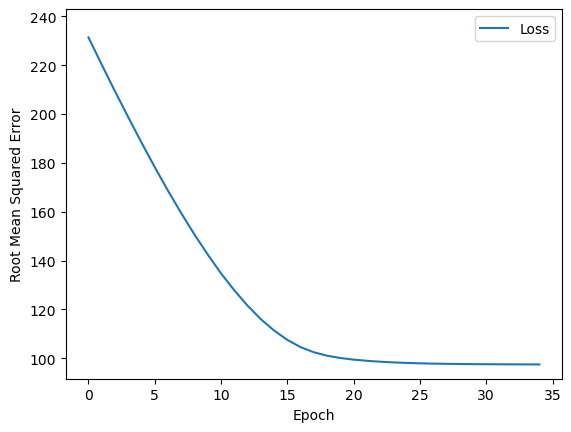


: Evaluate the new model against the test set:
30/30 [==============================] - 0s 1ms/step - loss: 9321.5557 - root_mean_squared_error: 96.5482


[9321.5556640625, 96.54820251464844]

In [28]:
# The following variables are the hyperparameters.
learning_rate = 0.04
epochs = 35

# Build the model, this time passing in the feature_cross_feature_layer:
my_model = create_model(inputs, outputs, learning_rate)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

# Print out the model summary.
my_model.summary(expand_nested=True)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

## Adjusting the resolution of the feature cross

Notice that `resolution_in_degrees` is set to 1.0. Therefore, each cell represents an area of 1.0 degree of latitude by 1.0 degree of longitude, which corresponds to a cell of 110 km by 90 km.  This resolution defines a rather large neighborhood.

In [29]:
resolution_in_degrees = 0.4

# Create a list of numbers representing the bucket boundaries for latitude.
latitude_boundaries = list(np.arange(int(min(train_df['latitude'])),
                                     int(max(train_df['latitude'])),
                                     resolution_in_degrees))

# Create a Discretization layer to separate the latitude data into buckets.
latitude = tf.keras.layers.Discretization(
    bin_boundaries=latitude_boundaries,
    name='discretization_latitude')(inputs.get('latitude'))

# Create a list of numbers representing the bucket boundaries for longitude.
longitude_boundaries = list(np.arange(int(min(train_df['longitude'])),
                                      int(max(train_df['longitude'])),
                                      resolution_in_degrees))

# Create a Discretization layer to separate the longitude data into buckets.
longitude = tf.keras.layers.Discretization(
    bin_boundaries=longitude_boundaries,
    name='discretization_longitude')(inputs.get('longitude'))

# Cross the latitude and longitude features into a single one-hot vector.
feature_cross = tf.keras.layers.HashedCrossing(
    num_bins=len(latitude_boundaries) * len(longitude_boundaries),
    output_mode='one_hot',
    name='cross_latitude_longitude')([latitude, longitude])

dense_output = layers.Dense(units=1, name='dense_layer')(feature_cross)

# Define an output dictionary we'll send to the model constructor.
outputs = {
  'dense_output': dense_output
}

Epoch 1/35
170/170 [==============================] - 0s 1ms/step - loss: 53706.1406 - root_mean_squared_error: 231.7458
Epoch 2/35
170/170 [==============================] - 0s 1ms/step - loss: 48960.7266 - root_mean_squared_error: 221.2707
Epoch 3/35
170/170 [==============================] - 0s 1ms/step - loss: 44514.5273 - root_mean_squared_error: 210.9847
Epoch 4/35
170/170 [==============================] - 0s 1ms/step - loss: 40351.4727 - root_mean_squared_error: 200.8768
Epoch 5/35
170/170 [==============================] - 0s 1ms/step - loss: 36505.5078 - root_mean_squared_error: 191.0641
Epoch 6/35
170/170 [==============================] - 0s 1ms/step - loss: 32945.3242 - root_mean_squared_error: 181.5085
Epoch 7/35
170/170 [==============================] - 0s 1ms/step - loss: 29666.8164 - root_mean_squared_error: 172.2406
Epoch 8/35
170/170 [==============================] - 0s 1ms/step - loss: 26684.1426 - root_mean_squared_error: 163.3528
Epoch 9/35
170/170 [============

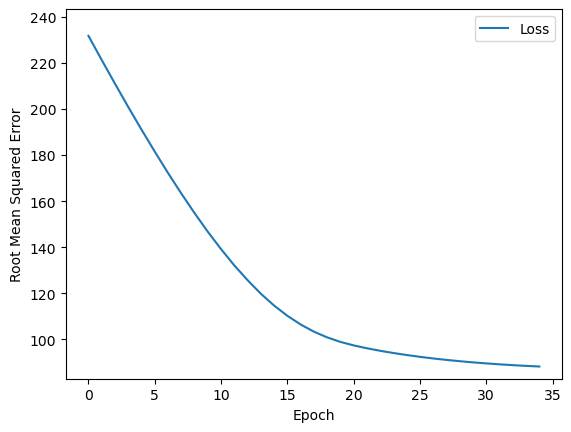


: Evaluate the new model against the test set:
30/30 [==============================] - 0s 2ms/step - loss: 7854.2866 - root_mean_squared_error: 88.6244


[7854.28662109375, 88.6244125366211]

In [30]:
# The following variables are the hyperparameters.
learning_rate = 0.04
epochs = 35

# Build the model, this time passing in the feature_cross_feature_layer:
my_model = create_model(inputs, outputs, learning_rate)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

# Print out the model summary.
my_model.summary(expand_nested=True)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

After all this treatment, we reduced the RMSE in $ 110.3 - 88.6 = 21.7 $, i.e., $ (21.7 / 110.3) * 100 = 19.7  $%